In [ ]:
import functions as func
import xgboost as xgb
import config as cfg
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.utils import concordance_index
from matplotlib.gridspec import GridSpec
from sklearn.calibration import calibration_curve, CalibrationDisplay
import warnings
from scipy.stats import kendalltau
from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter, CoxPHFitter

In [ ]:
warnings.simplefilter("ignore")
np.random.seed(cfg.kSeed)

def objective_clayton(predt, dtrain):
    '''
    Objective function for the Clayton-boost.

    :param np.ndarray predt: Predicted values
    :param xgb.DMatrix dtrain: Training data
    :return: The gradient and hessian of the loss function
    '''
    delta_loc = dtrain.get_float_info('label_lower_bound')
    grad = func.gradient(predt, dtrain,std_S,std_C,delta_loc,theta)
    hess = func.hessian(predt, dtrain,std_S,std_C,delta_loc,theta)
    return grad, hess


def objective_ind(predt, dtrain):
    '''
    Objective function for XGBoost AFT assuming independent censoring.

    :param np.ndarray predt: Predicted values
    :param xgb.DMatrix dtrain: Training data
    :return: The gradient and hessian of the loss function
    '''
    delta = dtrain.get_float_info('label_lower_bound')
    grad = func.gradient_ind(predt, dtrain,std_S,std_C,delta,theta)
    hess = func.hessian_ind(predt, dtrain,std_S,std_C,delta,theta)
    return grad, hess

def score_survival_model_my(predt, dtrain):
    '''
    Evaluation method for parameter tuning for Clayton-boost.

    :param array DMatrix: Predicted values
    :param DMatrix dtrain: Training data
    :return: The concordance index
    '''
    result = concordance_index(dtrain.get_label(),np.exp(predt),dtrain.get_float_info('label_lower_bound').astype(bool))
    return 'C-index',result

def score_survival_model_aft(predt, dtrain):
    '''
    Evaluation method for parameter tuning for XGBoost AFT assuming independent censoring.

    :param array DMatrix: Predicted values
    :param DMatrix dtrain: Training data
    :return: The concordance index
    '''
    y_upper_bound = np.where(dtrain.get_float_info('label_upper_bound')==np.inf, 0, 1)
    result = concordance_index(dtrain.get_float_info('label_lower_bound'),predt,y_upper_bound.astype(bool))
    return 'C-index',result

results_10 = {}
results_c_10 = {}
results_prob_10 = {}

step = cfg.step

eval_method = score_survival_model_my
eval_method_aft = score_survival_model_aft
state = True

xgb_cv_result = np.empty((5,3))
xgb_aft_cv_result = np.empty((5,3))
i = 0

In [ ]:
for seed in cfg.state_list:
    results = pd.DataFrame()
    results_c = pd.DataFrame()
    results_prob = pd.DataFrame()
    for theta in cfg.theta_list:

        print('Theta: ', theta)

        #-------------- Simulate Data ------------------

        dtrain, dtest, delta, delta_t, std_S, std_C, X1_reshape, X1_reshape_t, y, y_t, T, U, T_t, U_t  = func.generate_data4(cfg.lambda1, cfg.lambda2, cfg.k1, cfg.k2, theta, state = seed)

        dtrain_aft= xgb.DMatrix(X1_reshape)
        y_lower_bound = np.where(T<U, T, U)
        y_upper_bound = np.where(T<U, T, +np.inf)
        dtrain_aft.set_float_info('label_lower_bound', y_lower_bound)
        dtrain_aft.set_float_info('label_upper_bound', y_upper_bound)
        
        dtest_aft= xgb.DMatrix(X1_reshape_t)
        y_lower_bound_t = np.where(T_t<U_t, T_t, U_t)
        y_upper_bound_t = np.where(T_t<U_t, T_t, +np.inf)
        dtest_aft.set_float_info('label_lower_bound', y_lower_bound_t)
        dtest_aft.set_float_info('label_upper_bound', y_upper_bound_t)

        # ------------------ CV -----------------------------


        params = {'eta': cfg.eta,
              'tree_method':'hist',
              'seed': seed,
              'disable_default_eval_metric': 1,
              'max_depth' : cfg.max_depth,
             'min_child_weight': 0,
                 'nthread' : -1}

        xgb_my = xgb.cv(params,dtrain,num_boost_round=5000,nfold = 2, obj = objective_clayton, feval=eval_method,
                        maximize = state,early_stopping_rounds=500
                        ,shuffle = True, seed = seed                 
                        )

        kBoostRound_my = len(xgb_my)

        bst = xgb.train({'tree_method': 'hist', 'seed': seed,
               'disable_default_eval_metric': 1, 'eta' : cfg.eta, 'max_depth' : cfg.max_depth, 'min_child_weight': 0,'nthread' : -1
               },
              dtrain=dtrain,
              num_boost_round=kBoostRound_my,
              obj=objective_clayton,
              feval=eval_method,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              verbose_eval=False) 


        y_exp_test = np.exp(bst.predict(dtest))


        if cfg.dist_s == 'weibull':
            params_aft = {'objective': 'survival:aft',
                      'eval_metric': 'aft-nloglik',
                      'aft_loss_distribution': 'extreme',
                      'aft_loss_distribution_scale': std_S,
                      'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
                      'disable_default_eval_metric': 1,
                      'min_child_weight': 0,
                      'nthread' : -1}
        elif cfg.dist_s == 'loglogistic':
            params_aft = {'objective': 'survival:aft',
                      'eval_metric': 'aft-nloglik',
                      'aft_loss_distribution': 'logistic',
                      'aft_loss_distribution_scale': std_S,
                      'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
                      'disable_default_eval_metric': 1,
                      'min_child_weight': 0,
                      'nthread' : -1}
        elif cfg.dist_s == 'lognormal':
            params_aft = {'objective': 'survival:aft',
                      'eval_metric': 'aft-nloglik',
                      'aft_loss_distribution': 'normal',
                      'aft_loss_distribution_scale': std_S,
                      'tree_method': 'hist', 'learning_rate': cfg.eta2, 'max_depth': cfg.max_depth,
                      'disable_default_eval_metric': 1,
                      'min_child_weight': 0,
                      'nthread' : -1}

        xgb_aft = xgb.cv(params_aft,dtrain_aft,num_boost_round=5000,nfold = 2,
                     feval=eval_method_aft,maximize = state,early_stopping_rounds=500
                     ,shuffle = True, seed = seed
                     )

        kBoostRound_aft = len(xgb_aft)

        bst_aft = xgb.train(params_aft, dtrain_aft, num_boost_round=kBoostRound_aft,feval=eval_method_aft,
                        evals=[(dtrain_aft, 'dtrain'), (dtest_aft, 'dtest')], verbose_eval=False
                        )

        y_pred_aft = bst_aft.predict(dtest_aft)



        #-------------- Lifelines AFT ------------------

        if cfg.dist_s == 'weibull':
            aft = WeibullAFTFitter
        elif cfg.dist_s == 'loglogistic':
            aft = LogLogisticAFTFitter
        elif cfg.dist_s == 'lognormal':
            aft = LogNormalAFTFitter


        X_lifelines = pd.DataFrame(X1_reshape)
        X_lifelines_t = pd.DataFrame(X1_reshape_t)
        X_lifelines['not_censored'] = delta
        delta_t_t = np.ones(len(y_t))

        base_class = sklearn_adapter(aft, event_col='not_censored')
        wf = base_class()

        def score_survival_model_lifelines(model, X, y):
        '''
        Evaluation method for parameter tuning for the model from the Lifelines package.

        :param array DMatrix: Predicted values
        :param DMatrix dtrain: Training data
        :return: The concordance index
        '''
            prediction = model.predict(X)
            result = concordance_index(y,prediction,X['not_censored'].astype(bool))
            return result

        def grid_lifelines(X,y):
            '''
            Grid search for parameter tuning for the models from the Lifelines package.

            :param str X: Training data 
            :param str y: Response to the training data
            :return: Model made from the training data
            :return: Best parameters of the model
            '''


            eta_range = [0, 0.25, 0.5, 1, 2]
            param_grid = {'penalizer' : eta_range}
            gs = GridSearchCV(estimator=wf,
                              param_grid=param_grid,
                              scoring = score_survival_model_lifelines,
                              cv=2,
                              refit = True)

            model_cv = gs.fit(X,y)
            return(model_cv, gs.best_params_)

        aft_cv, aft_params = grid_lifelines(X_lifelines,y)
        penalizer1 = list(aft_params.values())[0]
        y_pred_lifelines = aft_cv.predict(X_lifelines_t)
        X_lifelines['time'] = y
        X_lifelines_t['time'] = y_t
        model = aft(penalizer=penalizer1).fit(X_lifelines,duration_col='time',event_col='not_censored')
        survprob_lifelines = np.array(1-model.predict_survival_function(X_lifelines_t, times = np.arange(y_t.min(),y_t.max(),step)).T)
        lifelines_surv = model.predict_survival_function(X_lifelines_t)


        #---------------------------Cox --------------

        cph = CoxPHFitter

        X_lifelines = pd.DataFrame(X1_reshape)
        X_lifelines_t = pd.DataFrame(X1_reshape_t)
        X_lifelines['not_censored'] = delta
        delta_t_t = np.ones(len(y_t))

        base_class = sklearn_adapter(cph, event_col='not_censored')
        wf = base_class()

        cox_cv, cox_params = grid_lifelines(X_lifelines,y)

        penalizer1 = list(cox_params.values())[0]

        y_pred_cox = cox_cv.predict(X_lifelines_t)
        X_lifelines['time'] = y
        X_lifelines_t['time'] = y_t
        model = CoxPHFitter(penalizer=penalizer1).fit(X_lifelines,duration_col='time',event_col='not_censored')
        survprob_cox = np.array(1-model.predict_survival_function(X_lifelines_t, times = np.arange(y_t.min(),y_t.max(),step)).T)

        #-------------- Comparison ------------------

        c_cox = round(concordance_index(y_t,y_pred_cox,delta_t.astype(bool)),4)
        c_lifelines = round(concordance_index(y_t,y_pred_lifelines,delta_t.astype(bool)),4)
        c_xgboost_ind = round(concordance_index(y_t,y_pred_aft,delta_t.astype(bool)),4)
        c_xgboost_my = round(concordance_index(y_t,y_exp_test,delta_t.astype(bool)),4)

        X_S = np.array(X1_reshape_t[:,0])
        y_S= np.array(y_t)
        y_S_pred= np.array(y_exp_test)
        y_S_aft= np.array(y_pred_aft)
        y_S_lifelines = np.array(y_pred_lifelines)
        y_S_cox = np.array(y_pred_cox)

        mae_cox = round(mean_absolute_error(y_S, y_S_cox),4)
        mae_lifelines = round(mean_absolute_error(y_S, y_S_lifelines),4)
        mae_xgboost_ind = round(mean_absolute_error(y_S, y_S_aft),4)
        mae_xgboost_my = round(mean_absolute_error(y_S, y_S_pred),4)

        cen = (len(y_t)-len(y_S))/(len(y_t))

        df_c = pd.DataFrame([[c_cox,c_lifelines,c_xgboost_ind,c_xgboost_my, cen]],
                          columns=['Cox','std-AFT', 'std-boost', 'clayton-boost', 'Censored'], index = [float(theta)] )


        results_c = results_c.append(df_c)

        df = pd.DataFrame([[mae_cox,mae_lifelines,mae_xgboost_ind,mae_xgboost_my, cen]],
                          columns=['Cox','std-AFT', 'std-boost', 'clayton-boost', 'Censored'], index = [float(theta)] )

        results = results.append(df)


        j = 0
        for i in np.arange(y_t.min(),y_t.max(),step):
            s_t = np.exp(-(i/(y_exp_test))**(1/std_S))
            if j == 0:
                survprob = np.exp(-(i/(y_exp_test))**(1/std_S))
                j += 1
            else:
                survprob = np.c_[survprob,s_t]

        j = 0
        for i in np.arange(y_t.min(),y_t.max(),step):
            s_t = np.exp(-(i/(y_pred_aft))**(1/std_S))
            if j == 0:
                survprob_aft = np.exp(-(i/(y_pred_aft))**(1/std_S))
                j += 1
            else:
                survprob_aft = np.c_[survprob_aft,s_t]

        y_str =  np.vstack((delta, y)).T
        y_str = np.core.records.fromarrays(y_str.transpose(),
                                                     names='delta, y, col3',
                                                     formats = 'bool, f8')
        y_str_t =  np.vstack((delta_t, y_t)).T
        y_str_t = np.core.records.fromarrays(y_str_t.transpose(),
                                                     names='delta, y, col3',
                                                     formats = 'bool, f8')

        y_l = []
        prob_pred = []
        prob_aft = []
        prob_cox = []
        prob_lifelines = []
        for j in range(len(survprob)):
            k = 0
            for i in np.arange(y_t.min(),y_t.max(),step):
                if k < len(survprob[0]):
                    if i <= y_t[j]:
                        y_l.append(0)
                    else:
                        y_l.append(1)
                    prob_pred.append(survprob[j][k])
                    prob_aft.append(survprob_aft[j][k])
                    prob_cox.append(survprob_cox[j][k])
                    prob_lifelines.append(survprob_lifelines[j][k])
                    k+=1
                else: 
                    break

        y_l = np.array(y_l)
        prob_pred = np.array(prob_pred)
        prob_aft = np.array(prob_aft)
        prob_cox = np.array(prob_cox)
        prob_lifelines = np.array(prob_lifelines)
        
        df_prob = pd.DataFrame([[prob_cox,prob_lifelines,prob_aft,prob_pred, y_l]],
                          columns=['Cox','std-AFT', 'std-boost', 'clayton-boost', 'True'], index = [float(theta)] )

        results_prob = results_prob.append(df_prob)

    results_10[seed] = results
    results_c_10[seed] = results_c
    results_prob_10[seed] = results_prob

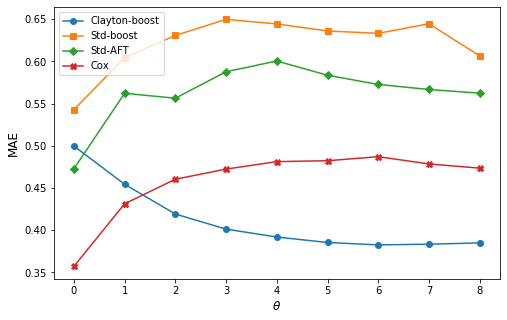

In [6]:
results_mean = (results_10[11].iloc[:-2]+results_10[22].iloc[:-2]+results_10[33].iloc[:-2]+results_10[44].iloc[:-2]+results_10[55].iloc[:-2]+results_10[66].iloc[:-2]+
                results_10[77].iloc[:-2] +results_10[88].iloc[:-2]+results_10[99].iloc[:-2]+results_10[111].iloc[:-2] + results_10[222].iloc[:-2]+results_10[333].iloc[:-2]+
                results_10[444].iloc[:-2]+results_10[555].iloc[:-2]+results_10[666].iloc[:-2]+results_10[777].iloc[:-2] +results_10[888].iloc[:-2]+results_10[999].iloc[:-2]+
                results_10[1111].iloc[:-2]+results_10[2222].iloc[:-2])/20

x = np.array(results_mean.index)

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, results_mean['clayton-boost'], label = 'Clayton-boost', marker='o')
plt.plot(x, results_mean['std-boost'], label = 'Std-boost',marker='s')
plt.plot(x, results_mean['std-AFT'], label = 'Std-AFT',marker='D')
plt.plot(x, results_mean['Cox'], label = 'Cox',marker='X')
plt.legend(loc='upper left')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.show()

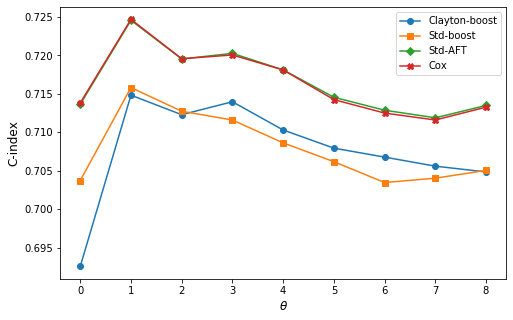

In [5]:
results_c_mean = (results_c_10[11].iloc[:-2]+results_c_10[22].iloc[:-2]+results_c_10[33].iloc[:-2]+results_c_10[44].iloc[:-2]+results_c_10[55].iloc[:-2]+results_c_10[66].iloc[:-2]
                 +results_c_10[77].iloc[:-2]+results_c_10[88].iloc[:-2]+results_c_10[99].iloc[:-2]+results_c_10[111].iloc[:-2]+results_c_10[222].iloc[:-2]+
                  results_c_10[333].iloc[:-2]+results_c_10[444].iloc[:-2]+results_c_10[555].iloc[:-2]+results_c_10[666].iloc[:-2]
                 +results_c_10[777].iloc[:-2]+results_c_10[888].iloc[:-2]+results_c_10[999].iloc[:-2]+results_c_10[1111].iloc[:-2]+results_c_10[2222].iloc[:-2])/20

x = np.array(results_c_mean.index)

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, results_c_mean['clayton-boost'], label = 'Clayton-boost', marker='o')
plt.plot(x, results_c_mean['std-boost'], label = 'Std-boost', marker='s')
plt.plot(x, results_c_mean['std-AFT'], label = 'Std-AFT', marker='D')
plt.plot(x, results_c_mean['Cox'], label = 'Cox', marker='X')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel('C-index', fontsize=12)
plt.show()

In [118]:
prob_true_dict = {}
prob_cox_dict = {}
prob_aft_dict = {}
prob_boost_dict = {}
prob_clayton_dict = {}
for j in range(0,9):
    for i in cfg.state_list:
        if i ==11:
            prob_cox = results_prob_10[i].iloc[j,0]
            prob_aft = results_prob_10[i].iloc[j,1]
            prob_boost = results_prob_10[i].iloc[j,2]
            prob_clayton = results_prob_10[i].iloc[j,3]
            if j == 0:
                prob_true = results_y[i][1e-10]
            else: 
                prob_true = results_y[i][j]
        else:
            prob_cox_1 = results_prob_10[i].iloc[j,0]
            prob_aft_1 = results_prob_10[i].iloc[j,1]
            prob_boost_1 = results_prob_10[i].iloc[j,2]
            prob_clayton_1 = results_prob_10[i].iloc[j,3]
            if j == 0:
                prob_true_1 = results_y[i][1e-10]
            else: 
                prob_true_1 = results_y[i][j]
            
            prob_cox = np.append(prob_cox,prob_cox_1)
            prob_aft = np.append(prob_aft,prob_aft_1)
            prob_boost = np.append(prob_boost,prob_boost_1)
            prob_clayton = np.append(prob_clayton,prob_clayton_1)
            prob_true = np.append(prob_true,prob_true_1)
            
    prob_cox_dict[j] = prob_cox
    prob_aft_dict[j] = prob_aft
    prob_boost_dict[j] = prob_boost
    prob_clayton_dict[j] = prob_clayton
    prob_true_dict[j] = prob_true

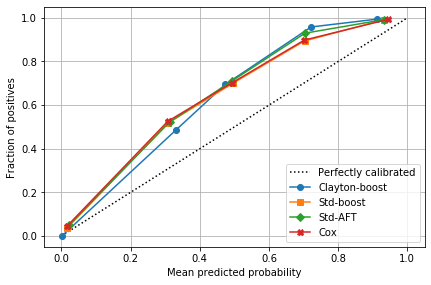

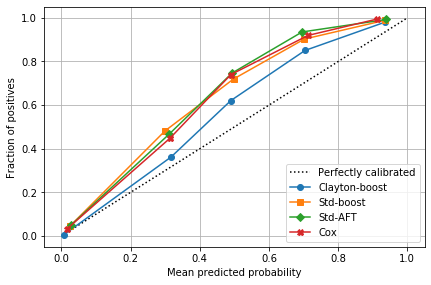

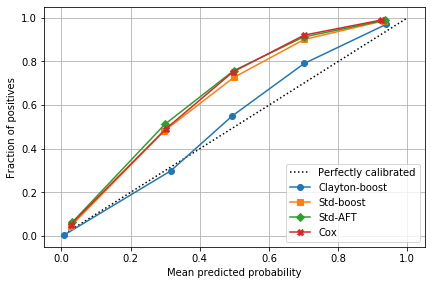

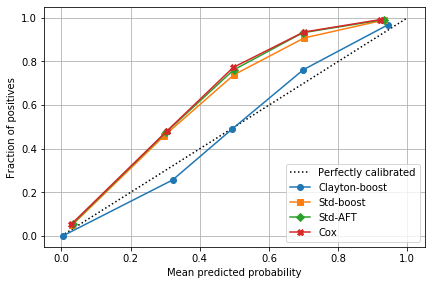

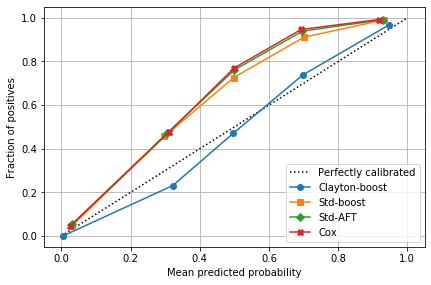

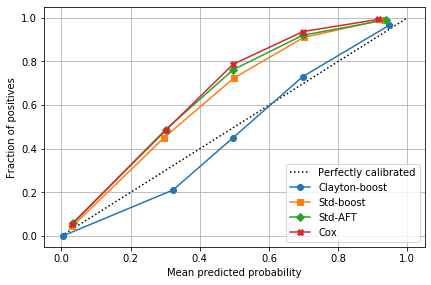

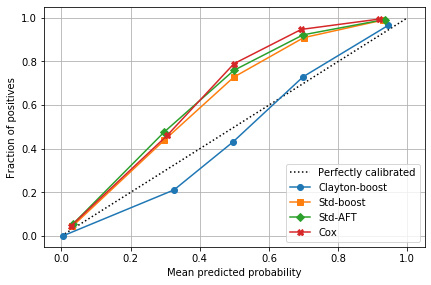

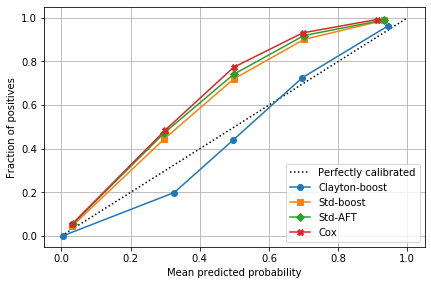

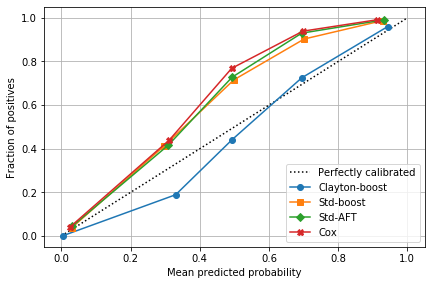

In [131]:
for i in range(0,9):
    fig = plt.figure(i,figsize=(15, 15))
    gs = GridSpec(3, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:1, :1])

    disp = CalibrationDisplay.from_predictions(prob_true_dict[i],1-prob_clayton_dict[i], ax = ax_calibration_curve, name='Clayton-boost', marker='o')
    disp = CalibrationDisplay.from_predictions(prob_true_dict[i],1-prob_boost_dict[i], ax = ax_calibration_curve, name='Std-boost', marker='s')
    disp = CalibrationDisplay.from_predictions(prob_true_dict[i],prob_aft_dict[i], ax = ax_calibration_curve, name='Std-AFT', marker='D')
    disp = CalibrationDisplay.from_predictions(prob_true_dict[i],prob_cox_dict[i], ax = ax_calibration_curve, name='Cox', marker='X')

    ax_calibration_curve.grid()
    ax_calibration_curve.plot()
    fig.show()